# DATA PRE PROCESSING
    

Pre Processing and EDA for Train dataset


We have these 4 data sets that we are to work with to get the loyalty scores.

1. Train.csv
2. historical_transactions.csv
3. merchants.csv
4. new_merchant_transactions

details of these tables have been mentioned below

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [ ]:
!pip install kaggle
from google.colab import files
#from datetime import datetime
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle competitions download -c elo-merchant-category-recommendation

 99% 611M/615M [00:14<00:00, 41.1MB/s]
100% 615M/615M [00:14<00:00, 44.6MB/s]


In [ ]:
!unzip elo-merchant-category-recommendation.zip

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Missing Data analysis on Train data set

In [ ]:
import os
os.chdir('/content/drive/MyDrive/case_study_1_var2')

In [ ]:
#About Train Data_Set
About_train = pd.read_excel("Data Dictionary.xlsx",header=2)

About_train

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


In [ ]:
#About Train
train_table  = pd.read_csv('train.csv',parse_dates = ["first_active_month"])

In [ ]:
train_table[0:1]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283


In [ ]:
print(" The date when the first card is issued :" ,min(train_table['first_active_month']))

 The date when the first card is issued : 2011-11-01 00:00:00


In [ ]:
#https://www.geeksforgeeks.org/python-pandas-series-dt-date/
def getFeaturesFromTrainAndTest(data):

    min_dte = data['first_active_month'].dt.date.min()

    #Time elapsed since first purchase
    data['time_elapsed'] = (data['first_active_month'].dt.date - min_dte).dt.days

    #Breaking first_active_month in year and month
    data['month'] = data['first_active_month'].dt.month
    data['year'] = data['first_active_month'].dt.year
    data['day'] = data['first_active_month'].dt.day

    return data

In [ ]:
train_table = getFeaturesFromTrainAndTest(train_table)

In [ ]:
# checking if there is any missing values

train_table.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
time_elapsed          0
month                 0
year                  0
day                   0
dtype: int64

# Test data set missing value analysis

In [ ]:
#About Test
test_table  = pd.read_csv('test.csv',parse_dates = ["first_active_month"])

In [ ]:
# checking if there is any missing values
test_table.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

### Test data set has one na value in first_active_month column

In [ ]:
# imputing missing date with most frequent date which is 2017-09-01
test_table.loc[test_table.first_active_month == test_table.first_active_month.value_counts().index[0]].head(1)

,first_active_month,card_id,feature_1,feature_2,feature_3
17,2017-09-01,C_ID_15489b42d3,4,3,0


In [ ]:
test_table = test_table.fillna(test_table.first_active_month[17])

In [ ]:
test_table = getFeaturesFromTrainAndTest(test_table)

In [ ]:
test_table.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
time_elapsed          0
month                 0
year                  0
day                   0
dtype: int64

# Missing data analysis and imputation for Historical Trasaction and New Merchant 

In [ ]:
#About Historical_Transaction Data_Set
About_Historical_Transaction = pd.read_excel("Data Dictionary.xlsx",header=2,sheet_name = "history")
About_Historical_Transaction

,Columns,Description
0,card_id,Card identifier
1,month_lag,month lag to reference date
2,purchase_date,Purchase date
3,authorized_flag,"Y' if approved, 'N' if denied"
4,category_3,anonymized category
5,installments,number of installments of purchase
6,category_1,anonymized category
7,merchant_category_id,Merchant category identifier (anonymized )
8,subsector_id,Merchant category group identifier (anonymized )
9,merchant_id,Merchant identifier (anonymized)


In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [ ]:
historical_transaction = reduce_mem_usage(pd.read_csv('historical_transactions.csv'))
new_merchants_trasaction = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv"))

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
#historical_transaction = historical_transaction.loc[historical_transaction.merchant_id.isna() == False]

In [ ]:
historical_transaction.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [ ]:

new_merchants_trasaction.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

### Mapping categorical values and imputation of missing values

In [ ]:
#Mapping above columns with ordinal value
#new_merchants_trasaction = new_merchants_trasaction.copy()

new_merchants_trasaction.category_1 = new_merchants_trasaction.category_1.map({'Y':1, 'N':0})
new_merchants_trasaction.category_3 = new_merchants_trasaction.category_3.map({'A':0, 'B':1, 'C':2})
new_merchants_trasaction.authorized_flag = new_merchants_trasaction.authorized_flag.map({'Y':1, 'N':0})
new_merchants_trasaction.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,1.0,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,1.0,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,1.0,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,1.0,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,1.0,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [ ]:
#Mapping above columns with ordinal values
#historical_transaction = historical_transaction.copy()

historical_transaction.category_1 = historical_transaction.category_1.map({'Y':1, 'N':0})
historical_transaction.category_3 = historical_transaction.category_3.map({'A':0, 'B':1, 'C':2})
historical_transaction.authorized_flag = historical_transaction.authorized_flag.map({'Y':1, 'N':0})
historical_transaction

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0.0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112356,1,C_ID_2863d2fa95,-1,1,1,1.0,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,1.0,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,0.0,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,0.0,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9


### Imputation of merchant Ids

In [ ]:
from tqdm import tqdm

In [ ]:
missing_id = historical_transaction.merchant_category_id.loc[historical_transaction.merchant_id.isnull()].unique()

In [ ]:
missing_id_nm = new_merchants_trasaction.merchant_category_id.loc[new_merchants_trasaction.merchant_id.isnull()].unique()

In [ ]:
'''m_dic = { i:new_merchants_trasaction.merchant_id.loc[new_merchants_trasaction.merchant_category_id == i].value_counts().index[0] 
         for i in missing_id_nm }

mi_dic = {i: list(new_merchants_trasaction.loc[(new_merchants_trasaction.merchant_category_id == i) 
              & (new_merchants_trasaction.merchant_id.isnull())].index)
          for i in missing_id_nm
          }

new_merchants_trasaction_imp = new_merchants_trasaction.copy()

for i in tqdm(missing_id_nm):

  for j in mi_dic[i]:

    new_merchants_trasaction_imp.merchant_id.iloc[j] = m_dic[i]'''

100%|██████████| 212/212 [05:57<00:00,  1.69s/it]


In [ ]:
historical_transaction_imp = historical_transaction.copy()


for i in tqdm(missing_id):
    
    mask = historical_transaction_imp.merchant_category_id == i

    value = historical_transaction_imp.loc[mask,"merchant_id"].value_counts().index[0]
    
    historical_transaction_imp.loc[mask,"merchant_id"] = historical_transaction_imp.loc[mask,"merchant_id"].fillna(value)

100%|██████████| 231/231 [02:25<00:00,  1.59it/s]


In [ ]:
#imputation Merchant id s in new_merchant

for i in tqdm(missing_id_nm):
    
    mask = new_merchants_trasaction.merchant_category_id == i
    value = new_merchants_trasaction.loc[mask,"merchant_id"].value_counts().index[0]
    
    #new_merchants_trasaction.merchant_id.loc[new_merchants_trasaction.merchant_category_id == i].fillna(value, inplace = True)
    
    new_merchants_trasaction.loc[mask,"merchant_id"] = new_merchants_trasaction.loc[mask,"merchant_id"].fillna(value)
        

100%|██████████| 212/212 [00:16<00:00, 13.16it/s]


In [ ]:
del mask

###Imputing Category 2 and 3

In [ ]:
clean_nm = new_merchants_trasaction.drop(columns = ['card_id','purchase_date','merchant_id'])
clm = list(new_merchants_trasaction.drop(columns = ['card_id','purchase_date','merchant_id']).columns)
print(" Index numbers for category2 , 3 in new merchant",clm.index('category_2'),clm.index('category_3'))

clean_ht = historical_transaction.drop(columns = ['card_id','purchase_date','merchant_id'])
clm = list(historical_transaction.drop(columns = ['card_id','purchase_date','merchant_id']).columns)
print(" Index numbers for category2 , 3 in historical data",clm.index('category_2'),clm.index('category_3'))

 Index numbers for category2 , 3 in new merchant 8 4
 Index numbers for category2 , 3 in historical data 8 4


In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter= 15, random_state=0)

clean_nm = np.round(imp.fit_transform(clean_nm))

clean_ht = np.round(imp.fit_transform(clean_ht))


In [ ]:
del imp

In [ ]:
#np.unique(clean_ht[:,8])

In [ ]:
'''import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
#imputer.fit_transform(X)

clean_nm = np.round(imputer.fit_transform(clean_nm))

clean_ht = np.round(imputer.fit_transform(clean_ht))'''

'import numpy as np\nfrom sklearn.impute import KNNImputer\n\nimputer = KNNImputer(n_neighbors=2)\n#imputer.fit_transform(X)\n\nclean_nm = np.round(imputer.fit_transform(clean_nm))\n\nclean_ht = np.round(imputer.fit_transform(clean_ht))'

In [ ]:
new_merchants_trasaction['category_3'] = clean_nm[:,4]
new_merchants_trasaction['category_2'] = clean_nm[:,8]

historical_transaction_imp['category_3'] = clean_ht[:,4]
historical_transaction_imp['category_2'] = clean_ht[:,8]

#Rounding off
new_merchants_trasaction['category_3'] = new_merchants_trasaction['category_3'].apply(lambda x : 2 if x > 2 else x)
new_merchants_trasaction['category_2'] = new_merchants_trasaction['category_2'].apply(lambda x : 5 if x > 5 else x)

In [ ]:
del clean_nm
del clean_ht

In [ ]:
new_merchants_trasaction.isna().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [ ]:
new_merchants_trasaction.describe()

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,1963031.0,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06
mean,1.0,1.343867e+02,3.214213e-02,6.829643e-01,5.781819e-01,4.309701e+02,1.476515e+00,NaN,2.152321e+00,1.088067e+01,2.597624e+01
std,0.0,1.015152e+02,1.763775e-01,1.584069e+00,6.287990e-01,2.463385e+02,4.994483e-01,NaN,1.500077e+00,6.038542e+00,1.012908e+01
min,1.0,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,-7.470703e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.0,6.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.780000e+02,1.000000e+00,-7.167969e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,1.0,1.100000e+02,0.000000e+00,1.000000e+00,1.000000e+00,3.670000e+02,1.000000e+00,-6.748047e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,1.0,2.120000e+02,0.000000e+00,1.000000e+00,1.000000e+00,6.830000e+02,2.000000e+00,-5.815430e-01,3.000000e+00,1.500000e+01,3.400000e+01
max,1.0,3.470000e+02,1.000000e+00,9.990000e+02,2.000000e+00,8.910000e+02,2.000000e+00,2.632500e+02,5.000000e+00,2.400000e+01,4.100000e+01


The mean and standerd deviation of purchase ammount in new_merchant_transaction is Nan even though there is no Nan or inf values in purchase ammount

In [ ]:
historical_transaction_imp.isna().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [ ]:
historical_transaction_imp.describe()

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07
mean,9.135450e-01,1.293256e+02,7.158571e-02,6.484954e-01,5.280233e-01,4.810130e+02,-4.487294e+00,6.134567e-02,2.093567e+00,1.056679e+01,2.684839e+01
std,2.810348e-01,1.042563e+02,2.578007e-01,2.795577e+00,6.131561e-01,2.493757e+02,3.588800e+00,1.123521e+03,1.497264e+00,6.366927e+00,9.692793e+00
min,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.000000e+00,5.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,1.000000e+00,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,1.000000e+00,2.120000e+02,0.000000e+00,1.000000e+00,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,1.000000e+00,3.470000e+02,1.000000e+00,9.990000e+02,2.000000e+00,8.910000e+02,0.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [ ]:
#Merging Both the transaction data sets

In [ ]:
transaction = historical_transaction_imp.append(new_merchants_trasaction, ignore_index=True)
transaction.describe()

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07
mean,9.190064e-01,1.296453e+02,6.909406e-02,6.506728e-01,5.311919e-01,4.778518e+02,-4.110560e+00,2.230874e-02,2.097278e+00,1.058662e+01,2.679329e+01
std,2.728253e-01,1.040926e+02,2.536140e-01,2.734985e+00,6.142772e-01,2.494821e+02,3.766495e+00,1.087456e+03,1.497510e+00,6.347145e+00,9.723248e+00
min,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.300000e+01,-7.470703e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.000000e+00,5.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.020000e+02,-7.000000e+00,-7.199051e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,1.000000e+00,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.540000e+02,-3.000000e+00,-6.875000e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,1.000000e+00,2.120000e+02,0.000000e+00,1.000000e+00,1.000000e+00,7.050000e+02,-1.000000e+00,-6.008651e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,1.000000e+00,3.470000e+02,1.000000e+00,9.990000e+02,2.000000e+00,8.910000e+02,2.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [ ]:
transaction.isna().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [ ]:
#historical_transactions = pd.get_dummies(historical_transaction_imp, columns=['category_2', 'category_3','authorized_flag'])
transactions = pd.get_dummies(transaction, columns=['category_2', 'category_3','authorized_flag'])

In [ ]:
transactions


,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,...,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0.0,category_3_1.0,category_3_2.0,authorized_flag_0,authorized_flag_1
0,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,...,1,0,0,0,0,1,0,0,0,1
1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,...,1,0,0,0,0,1,0,0,0,1
2,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,...,1,0,0,0,0,1,0,0,0,1
3,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,...,1,0,0,0,0,1,0,0,0,1
4,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075387,C_ID_1320dee851,142,0,0,309,M_ID_7754b67f3b,2,-0.701660,2018-04-06 14:36:52,19,...,0,0,1,0,0,1,0,0,0,1
31075388,C_ID_f112aa3381,158,0,0,560,M_ID_da063195b7,2,-0.694336,2018-03-07 13:19:18,15,...,1,0,0,0,0,1,0,0,0,1
31075389,C_ID_bd97b86450,69,0,1,278,M_ID_9a9ccb6544,1,-0.621094,2018-03-05 12:04:56,9,...,1,0,0,0,0,0,1,0,0,1
31075390,C_ID_c0513fd84f,130,0,0,367,M_ID_40c28d596f,1,-0.656738,2018-03-09 14:47:05,7,...,0,0,1,0,0,1,0,0,0,1


In [ ]:
del historical_transaction
del historical_transaction_imp
del new_merchants_trasaction

In [ ]:
#Dumping new transaction
import pickle 
pickle.dump((transactions),open('/content/drive/MyDrive/case_study_1_var2/transactions','wb'))

In [ ]:
transactions = reduce_mem_usage(pd.read_pickle('/content/drive/MyDrive/case_study_1_var2/transactions'))
transactions

Mem. usage decreased to 1422.52 Mb (12.7% reduction)


,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,...,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0.0,category_3_1.0,category_3_2.0,authorized_flag_0,authorized_flag_1
0,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,...,1,0,0,0,0,1,0,0,0,1
1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,...,1,0,0,0,0,1,0,0,0,1
2,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,...,1,0,0,0,0,1,0,0,0,1
3,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,...,1,0,0,0,0,1,0,0,0,1
4,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075387,C_ID_1320dee851,142,0,0,309,M_ID_7754b67f3b,2,-0.701660,2018-04-06 14:36:52,19,...,0,0,1,0,0,1,0,0,0,1
31075388,C_ID_f112aa3381,158,0,0,560,M_ID_da063195b7,2,-0.694336,2018-03-07 13:19:18,15,...,1,0,0,0,0,1,0,0,0,1
31075389,C_ID_bd97b86450,69,0,1,278,M_ID_9a9ccb6544,1,-0.621094,2018-03-05 12:04:56,9,...,1,0,0,0,0,0,1,0,0,1
31075390,C_ID_c0513fd84f,130,0,0,367,M_ID_40c28d596f,1,-0.656738,2018-03-09 14:47:05,7,...,0,0,1,0,0,1,0,0,0,1


### Feturizing purchase date

In [ ]:
def get_date_feature(df_m):

  df = df_m.copy()
  
  df['purchase_date'] = pd.to_datetime(df['purchase_date'])

  df['m_op'] = df['purchase_date'].dt.month
  df['y_op'] = df['purchase_date'].dt.year
  
  df['week_day'] = df['purchase_date'].dt.day.apply(lambda x : 0 if x > 4 else 1)
  df['weekend'] = df['purchase_date'].dt.day.apply(lambda x : 0 if x < 4 else 1)

  df['days'] = ((df['purchase_date'] - datetime.datetime(2011,11,1))).dt.days

  df['month_diff'] = ((df['purchase_date'] - datetime.datetime(2011,11,1))).dt.days//30 #Month diff from the date of first card activation
  
  df['month_diff'] += df['month_lag']
    
  df = pd.get_dummies(df, columns =['m_op','y_op'])
 
  agg_func_1 = {
      'week_day' : ['sum','mean'],
      'weekend' : ['sum','mean'],
      'month_diff' : ['mean','min','max','std'],
      'month_lag' : ['mean','min','max','std']     
  }

  agg_func_2 = { i : ['sum', 'mean'] for i in df.columns if ('m_op' in i) or ('y_op' in i)}
  
  df_1 = df.groupby('card_id').agg(agg_func_1)
  df_1.columns = [ "_".join(col).strip() for col in df_1.columns]
  df_1 = df_1.reset_index()

  df_2 = df.groupby('card_id').agg(agg_func_2)
  df_2.columns = ["_".join(col).strip() for col in  df_2.columns]
  df_2 = df_2.reset_index()

  df = df_1.merge(df_2, how = 'left', on = 'card_id')
  return df


In [ ]:
def get_purchase_features(df_main):
  df = df_main.copy()
  agg_d = {'purchase_amount' : ['sum']}

  df['purchase_date'] = pd.to_datetime(df['purchase_date'])

  df['m_op'] = df['purchase_date'].dt.month
  df['y_op'] = df['purchase_date'].dt.year

  df_m = df.groupby(['card_id', 'm_op']).agg(agg_d)

  #fm = pd.get_dummies(nm, columns = ['m_op'])
  df_m.columns = ["_".join(col).strip() for col in df_m.columns]
  df_m = df_m.reset_index()
  #print('Pass')
  df_m = pd.get_dummies(df_m, columns = ['m_op'])

  ar = np.array(df_m.drop(columns = ['card_id','purchase_amount_sum']))

  ar1 = np.array(df_m['purchase_amount_sum'])
  ar1 = ar1.reshape(-1,1)

  l1 = ['m_op_'+ str(i) for i in range(1,13)]

  df_m[l1] = ar1*ar
  df_m = df_m.drop(columns = ['purchase_amount_sum'])
  df_m = df_m.groupby('card_id').agg(['sum','mean'])

  #print('Pass')
  ######################################################

  df_y = df.groupby(['card_id', 'y_op']).agg(agg_d)

  #fm = pd.get_dummies(nm, columns = ['m_op'])
  df_y.columns = ["_".join(col).strip() for col in df_y.columns]
  df_y = df_y.reset_index()

  df_y = pd.get_dummies(df_y, columns = ['y_op'])

  ar = np.array(df_y.drop(columns = ['card_id','purchase_amount_sum']))

  ar1 = np.array(df_y['purchase_amount_sum'])
  ar1 = ar1.reshape(-1,1)

  l1 = ['y_op_2017','y_op_2018']

  df_y[l1] = ar1*ar
  df_y = df_y.drop(columns = ['purchase_amount_sum'])
  df_y = df_y.groupby('card_id').agg(['sum','mean'])

  df = df_y.merge(df_m, on = 'card_id', how = 'left')

  df.columns = ["_".join(col).strip() for col in df.columns]
  df.reset_index(inplace = True)
  return df

In [ ]:
tr_purchase_f = get_purchase_features(transactions)
tr_date_f = get_date_feature(transactions)

In [ ]:
tr_purchase_f.head(5)

,card_id,y_op_2017_sum,y_op_2017_mean,y_op_2018_sum,y_op_2018_mean,m_op_1_sum,m_op_1_mean,m_op_2_sum,m_op_2_mean,m_op_3_sum,...,m_op_8_sum,m_op_8_mean,m_op_9_sum,m_op_9_mean,m_op_10_sum,m_op_10_mean,m_op_11_sum,m_op_11_mean,m_op_12_sum,m_op_12_mean
0,C_ID_00007093c1,-64.908653,-32.454327,-13.264998,-6.632499,-5.686047,-0.473837,-7.584752,-0.632063,-5.712629,...,-6.402827,-0.533569,-2.946293,-0.245524,-10.423035,-0.868586,-3.068579,-0.255715,-5.979800,-0.498317
1,C_ID_0001238066,-43.971298,-21.985649,-43.326061,-21.663031,-13.581893,-1.697737,-14.894008,-1.861751,-9.754944,...,0.000000,0.000000,-1.302783,-0.162848,-6.798941,-0.849868,-14.426699,-1.803337,-21.442877,-2.680360
2,C_ID_0001506ef0,-29.378319,-14.689159,-6.670827,-3.335413,-4.593966,-0.417633,-5.504106,-0.500373,-6.991973,...,-0.217313,-0.019756,-0.336023,-0.030548,-0.872199,-0.079291,-3.591547,-0.326504,-11.071218,-1.006474
3,C_ID_0001793786,-37.015015,-37.015015,0.000000,0.000000,0.414296,0.034525,1.147470,0.095622,-0.846068,...,-10.843852,-0.903654,-5.938868,-0.494906,-5.497975,-0.458165,1.676027,0.139669,-1.905029,-0.158752
4,C_ID_000183fdda,-45.617786,-22.808893,-29.810974,-14.905487,-7.581191,-0.842355,-15.638963,-1.737663,-5.111084,...,-0.226840,-0.025204,-13.915015,-1.546113,-15.177362,-1.686374,-3.359763,-0.373307,-12.938804,-1.437645


In [ ]:
tr_date_f.head(5)

,card_id,week_day_sum,week_day_mean,weekend_sum,weekend_mean,month_diff_mean,month_diff_min,month_diff_max,month_diff_std,month_lag_mean,...,m_op_10_sum,m_op_10_mean,m_op_11_sum,m_op_11_mean,m_op_12_sum,m_op_12_mean,y_op_2017_sum,y_op_2017_mean,y_op_2018_sum,y_op_2018_mean
0,C_ID_00007093c1,26,0.172185,130,0.860927,64.516556,52,80,7.157145,-5.748344,...,17.0,0.112583,6.0,0.039735,12.0,0.079470,127.0,0.841060,24.0,0.158940
1,C_ID_0001238066,25,0.167785,131,0.879195,73.543624,66,81,3.439601,-1.261745,...,11.0,0.073826,23.0,0.154362,37.0,0.248322,73.0,0.489933,76.0,0.510067
2,C_ID_0001506ef0,8,0.117647,64,0.941176,66.676471,50,78,8.616959,-4.661765,...,3.0,0.044118,7.0,0.102941,18.0,0.264706,53.0,0.779412,15.0,0.220588
3,C_ID_0001793786,25,0.101215,227,0.919028,66.530364,54,77,5.391774,-2.744939,...,20.0,0.080972,21.0,0.085020,10.0,0.040486,247.0,1.000000,0.0,0.000000
4,C_ID_000183fdda,25,0.161290,132,0.851613,71.716129,64,81,4.119568,-2.187097,...,25.0,0.161290,9.0,0.058065,26.0,0.167742,88.0,0.567742,67.0,0.432258


In [ ]:
#Dumping these two data frames
pickle.dump((tr_purchase_f,tr_date_f),open('/content/drive/MyDrive/case_study_1_var2/transactions_dt_pr_features','wb'))

In [ ]:
tr_purchase_f,tr_date_f = pickle.load(open('/content/drive/MyDrive/case_study_1_var2/transactions_dt_pr_features','rb'))

### Cleaning Feturizing Merchant

In [ ]:
about_merchant = pd.read_excel("Data Dictionary.xlsx",header=2,sheet_name = "merchant")
about_merchant

,Columns,Description
0,merchant_id,Unique merchant identifier
1,merchant_group_id,Merchant group (anonymized )
2,merchant_category_id,Unique identifier for merchant category (anony...
3,subsector_id,Merchant category group (anonymized )
4,numerical_1,anonymized measure
5,numerical_2,anonymized measure
6,category_1,anonymized category
7,most_recent_sales_range,Range of revenue (monetary units) in last acti...
8,most_recent_purchases_range,Range of quantity of transactions in last acti...
9,avg_sales_lag3,Monthly average of revenue in last 3 months di...


In [ ]:
#Loading the merchants data set
merchants = reduce_mem_usage(pd.read_csv("/content/merchants.csv"))
merchants.isnull().sum()

Mem. usage decreased to 30.32 Mb (46.0% reduction)


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [ ]:
#Describing non categorical numerical features
merchants[["numerical_1","numerical_2",'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6','category_4','avg_purchases_lag12']].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_purchases_lag12
count,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346960e+05
mean,0.011482,0.008095,13.839176,inf,2.994108,2.165529e+01,inf,5.947397,inf
std,0.000000,0.000000,2395.453369,NaN,0.095247,3.947046e+03,NaN,0.394936,NaN
min,-0.057465,-0.057465,-82.129997,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,9.832954e-02
25%,-0.057465,-0.057465,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.983333e-01
50%,-0.057465,-0.057465,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.043361e+00
75%,-0.047546,-0.047546,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.266480e+00
max,183.750000,182.125000,851844.625000,inf,3.000000,1.513959e+06,inf,6.000000,inf


In [ ]:
#imputting missing values with mean
merchants = merchants[['merchant_id','numerical_1', 'numerical_2','merchant_group_id',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4']]

na_imputer = lambda x: x.fillna(x.mean())
inf_imputer = lambda x: x.replace([np.inf, -np.inf], x.value_counts().index[0])

merchants_clean = merchants.copy()

merchants_clean[['avg_purchases_lag3']] = merchants_clean[['avg_purchases_lag3']].apply(inf_imputer)
merchants_clean[['avg_purchases_lag6']] = merchants_clean[['avg_purchases_lag6']].apply(inf_imputer)
merchants_clean[['avg_purchases_lag12']] = merchants_clean[['avg_purchases_lag12']].apply(inf_imputer)

merchants_clean[['avg_sales_lag3']] = merchants_clean[['avg_sales_lag3']].apply(na_imputer)
merchants_clean[['avg_sales_lag6']] = merchants_clean[['avg_sales_lag6']].apply(na_imputer)
merchants_clean[['avg_sales_lag12']] = merchants_clean[['avg_sales_lag12']].apply(na_imputer)


In [ ]:
merchants_clean.category_4 = merchants_clean.category_4.apply( lambda x : 1 if x == 'Y' else 0)
merchants_clean

,merchant_id,numerical_1,numerical_2,merchant_group_id,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
0,M_ID_838061e48c,-0.057465,-0.057465,8353,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,0
1,M_ID_9339d880ad,-0.057465,-0.057465,3184,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,0
2,M_ID_e726bbae1e,-0.057465,-0.057465,447,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,0
3,M_ID_a70e9c5f81,-0.057465,-0.057465,5026,E,E,13.839176,1.666667,3,21.655289,4.666667,6,25.231224,3.833333,12,1
4,M_ID_64456c37ce,-0.057465,-0.057465,2228,E,E,13.839176,0.500000,3,21.655289,0.361111,6,25.231224,0.347222,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,3.173828,-0.047546,1145,A,A,1.000000,1.022618,3,0.990000,1.019505,6,1.000000,1.024796,12,1
334692,M_ID_725a60d404,-0.057465,-0.057465,35,A,A,0.890000,0.927684,3,0.780000,0.813473,6,0.590000,0.606765,12,1
334693,M_ID_f2045dd267,-0.057465,-0.057465,35,A,A,0.960000,0.982957,3,0.900000,0.924769,6,0.740000,0.750763,8,1
334694,M_ID_9139332ccc,-0.057465,-0.057465,35,A,A,0.940000,0.919558,3,0.820000,0.783000,6,0.650000,0.584000,12,1


In [ ]:
import statistics as st
from scipy import stats as s

def std(x):
  return np.std(x)

def mode(x):
  return int(s.mode(x)[0])
def mode_c(x):
  return x.value_counts().index[0]

In [ ]:
def agg_merchant(df):

  
  dic_agg = {i:['mean'] for i in df.columns if (i not in ['merchant_id','category_4'])}
  dic_agg['most_recent_sales_range'] = ['nunique']
  dic_agg['most_recent_purchases_range'] = ['nunique']
  dic_agg['merchant_group_id'] = ['nunique']
  dic_agg['category_4'] = ['nunique','mean']


  agg = df.groupby(['merchant_id']).agg(dic_agg)
  
  agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
  agg.reset_index(inplace=True)

  return agg

In [ ]:
merchants_clean = agg_merchant(merchants_clean)
#merchants_clean_t = pd.get_dummies(merchants_clean_t, columns=['most_recent_sales_range_mode_c', 'most_recent_purchases_range_mode_c','category_4_mode_c'])
merchants_clean

,merchant_id,numerical_1_mean,numerical_2_mean,merchant_group_id_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique,avg_sales_lag3_mean,avg_purchases_lag3_mean,active_months_lag3_mean,avg_sales_lag6_mean,avg_purchases_lag6_mean,active_months_lag6_mean,avg_sales_lag12_mean,avg_purchases_lag12_mean,active_months_lag12_mean,category_4_nunique,category_4_mean
0,M_ID_000025127f,-0.057465,-0.057465,1,1,1,1.29,1.880342,3.0,1.26,2.228632,6.0,1.08,2.089744,12.0,1,1.0
1,M_ID_0000699140,-0.057465,-0.057465,1,1,1,0.99,0.997832,3.0,1.04,1.002168,6.0,1.24,1.154878,12.0,1,0.0
2,M_ID_00006a5552,-0.057465,-0.057465,1,1,1,1.21,1.000000,3.0,1.18,1.000000,6.0,1.22,1.035714,12.0,1,0.0
3,M_ID_000087311e,-0.057465,-0.057465,1,1,1,0.93,1.314815,3.0,0.95,1.300926,6.0,0.78,1.261574,12.0,1,1.0
4,M_ID_0000ab0b2d,-0.057465,-0.057465,1,1,1,1.05,1.089897,3.0,0.99,1.057279,6.0,1.06,1.135640,12.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334628,M_ID_fffeeb852d,0.031769,0.031769,1,1,1,0.72,1.016340,3.0,0.81,1.125817,6.0,0.75,1.077206,12.0,1,0.0
334629,M_ID_fffef87522,0.051605,0.051605,1,1,1,1.28,1.728070,3.0,1.34,1.879825,6.0,1.45,1.914846,12.0,1,0.0
334630,M_ID_ffff0af8e7,-0.057465,-0.057465,1,1,1,0.90,0.909420,3.0,0.91,0.935990,6.0,1.07,1.147343,12.0,1,0.0
334631,M_ID_ffff655e2c,-0.057465,-0.057465,1,1,1,0.61,0.788889,3.0,0.55,0.772222,6.0,0.44,0.650000,12.0,1,0.0


In [ ]:
merchants_clean.isna().sum()

merchant_id                            0
numerical_1_mean                       0
numerical_2_mean                       0
merchant_group_id_nunique              0
most_recent_sales_range_nunique        0
most_recent_purchases_range_nunique    0
avg_sales_lag3_mean                    0
avg_purchases_lag3_mean                0
active_months_lag3_mean                0
avg_sales_lag6_mean                    0
avg_purchases_lag6_mean                0
active_months_lag6_mean                0
avg_sales_lag12_mean                   0
avg_purchases_lag12_mean               0
active_months_lag12_mean               0
category_4_nunique                     0
category_4_mean                        0
dtype: int64

In [ ]:
import pickle 
pickle.dump((merchants_clean),open('/content/drive/MyDrive/case_study_1_var2/merchants_clean_v1.pkl','wb'))

In [ ]:
merchants_clean = reduce_mem_usage(pd.read_pickle('/content/drive/MyDrive/case_study_1_var2/merchants_clean_v1.pkl'))
merchants_clean

Mem. usage decreased to 13.40 Mb (62.5% reduction)


,merchant_id,numerical_1_mean,numerical_2_mean,merchant_group_id_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique,avg_sales_lag3_mean,avg_purchases_lag3_mean,active_months_lag3_mean,avg_sales_lag6_mean,avg_purchases_lag6_mean,active_months_lag6_mean,avg_sales_lag12_mean,avg_purchases_lag12_mean,active_months_lag12_mean,category_4_nunique,category_4_mean
0,M_ID_000025127f,-0.057465,-0.057465,1,1,1,1.29,1.879883,3.0,1.26,2.228516,6.0,1.08,2.089844,12.0,1,1.0
1,M_ID_0000699140,-0.057465,-0.057465,1,1,1,0.99,0.998047,3.0,1.04,1.001953,6.0,1.24,1.155273,12.0,1,0.0
2,M_ID_00006a5552,-0.057465,-0.057465,1,1,1,1.21,1.000000,3.0,1.18,1.000000,6.0,1.22,1.036133,12.0,1,0.0
3,M_ID_000087311e,-0.057465,-0.057465,1,1,1,0.93,1.314453,3.0,0.95,1.300781,6.0,0.78,1.261719,12.0,1,1.0
4,M_ID_0000ab0b2d,-0.057465,-0.057465,1,1,1,1.05,1.089844,3.0,0.99,1.057617,6.0,1.06,1.135742,12.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334628,M_ID_fffeeb852d,0.031769,0.031769,1,1,1,0.72,1.016602,3.0,0.81,1.125977,6.0,0.75,1.077148,12.0,1,0.0
334629,M_ID_fffef87522,0.051605,0.051605,1,1,1,1.28,1.728516,3.0,1.34,1.879883,6.0,1.45,1.915039,12.0,1,0.0
334630,M_ID_ffff0af8e7,-0.057465,-0.057465,1,1,1,0.90,0.909180,3.0,0.91,0.936035,6.0,1.07,1.147461,12.0,1,0.0
334631,M_ID_ffff655e2c,-0.057465,-0.057465,1,1,1,0.61,0.789062,3.0,0.55,0.772461,6.0,0.44,0.649902,12.0,1,0.0


In [ ]:
#Merging new_transactions with merchants_clean
transaction_m = transactions.merge(merchants_clean, on = 'merchant_id', how = 'left')
transaction_m

,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,...,avg_purchases_lag3_mean,active_months_lag3_mean,avg_sales_lag6_mean,avg_purchases_lag6_mean,active_months_lag6_mean,avg_sales_lag12_mean,avg_purchases_lag12_mean,active_months_lag12_mean,category_4_nunique,category_4_mean
0,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,...,1.082031,3.0,1.14,1.114258,6.0,1.19,1.157227,12.0,1,1.0
1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,...,1.051758,3.0,1.06,1.058594,6.0,1.05,1.062500,12.0,1,1.0
2,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,...,0.974609,3.0,0.98,0.967285,6.0,0.97,0.956543,12.0,1,1.0
3,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,...,1.053711,3.0,0.88,0.897461,6.0,0.86,0.864258,12.0,1,1.0
4,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,...,1.082031,3.0,1.14,1.114258,6.0,1.19,1.157227,12.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075387,C_ID_1320dee851,142,0,0,309,M_ID_7754b67f3b,2,-0.701660,2018-04-06 14:36:52,19,...,1.156250,3.0,1.39,1.185547,6.0,1.45,1.172852,12.0,1,0.0
31075388,C_ID_f112aa3381,158,0,0,560,M_ID_da063195b7,2,-0.694336,2018-03-07 13:19:18,15,...,0.972656,3.0,0.90,0.885254,6.0,0.88,0.875000,12.0,1,1.0
31075389,C_ID_bd97b86450,69,0,1,278,M_ID_9a9ccb6544,1,-0.621094,2018-03-05 12:04:56,9,...,1.033203,3.0,1.01,1.041992,6.0,0.99,1.028320,12.0,1,1.0
31075390,C_ID_c0513fd84f,130,0,0,367,M_ID_40c28d596f,1,-0.656738,2018-03-09 14:47:05,7,...,1.091797,3.0,0.94,1.051758,6.0,0.89,1.024414,12.0,1,0.0


In [ ]:
del transaction
del merchants_clean

### Merging with train 

In [ ]:
transaction_m.isnull().sum()

card_id                                0
city_id                                0
category_1                             0
installments                           0
merchant_category_id                   0
merchant_id                            0
month_lag                              0
purchase_amount                        0
purchase_date                          0
state_id                               0
subsector_id                           0
category_2_1.0                         0
category_2_2.0                         0
category_2_3.0                         0
category_2_4.0                         0
category_2_5.0                         0
category_3_0.0                         0
category_3_1.0                         0
category_3_2.0                         0
authorized_flag_0                      0
authorized_flag_1                      0
numerical_1_mean                       0
numerical_2_mean                       0
merchant_group_id_nunique              0
most_recent_sale

In [ ]:
def aggregate_transactions(df):

    agg_func = {
    'category_1': ['sum', 'mean'],

    'category_3_0.0': ['mean','sum'],
    'category_3_1.0': ['mean','sum'],
    'category_3_2.0': ['mean','sum'],

    'category_2_1.0': ['mean','sum'],
    'category_2_2.0': ['mean','sum'],
    'category_2_3.0': ['mean','sum'],
    'category_2_4.0': ['mean','sum'],
    'category_2_5.0': ['mean','sum'],

    'authorized_flag_0' :['mean','sum'],
    'authorized_flag_1' :['mean','sum'],

    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique',mode],

    'state_id': ['nunique',mode],
    'city_id': ['nunique',mode],
    'subsector_id': ['nunique',mode],

    'purchase_amount': ['sum', 'mean', 'max', 'min', std],
    'installments': ['sum', 'mean', 'max', 'min', std],  
    
    'numerical_1_mean' : ['sum', 'mean', 'max', 'min',std],
    'numerical_2_mean' : ['sum', 'mean', 'max', 'min',std],
    

    'merchant_group_id_nunique' : ['mean','sum'],
    'most_recent_sales_range_nunique' : ['mean','sum'],
    'most_recent_purchases_range_nunique' : ['mean','sum'],


    'avg_sales_lag3_mean' : ['sum', 'mean',std],
    'avg_purchases_lag3_mean':  ['sum', 'mean',std],
    'active_months_lag3_mean':['sum', 'mean',std],

    'avg_sales_lag6_mean':['sum', 'mean',std],
    'avg_purchases_lag6_mean':['sum', 'mean',std],
    'active_months_lag6_mean': ['sum', 'mean',std],

    'avg_sales_lag12_mean':['sum', 'mean', std],
    'avg_purchases_lag12_mean': ['sum', 'mean', std],
    'active_months_lag12_mean': ['sum', 'mean',std],

    'category_4_nunique' : ['sum','mean'],
    'category_4_mean' : ['sum', 'mean']

     }
    
    df_n = df.groupby('card_id').agg(agg_func)
    
    df_tr = (df.groupby('card_id')\
            .size()\
            .reset_index(name='transactions_count'))

    df_n.columns = ['_'.join(col).strip() for col in df_n.columns.values]

    df_n = df_n.merge(df_tr, how = 'left', on = 'card_id')

    

    return df_n   


In [ ]:

def aggregate_per_month(df):
    grouped = df.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max',std],
            'installments': ['count', 'sum', 'mean', 'min', 'max',std],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [ ]:
nm_tra_agg = aggregate_transactions(transaction_m)


In [ ]:
nm_tra_agg = nm_tra_agg.replace([np.inf, - np.inf], np.nan)
list_na = [i for i in range(90) if nm_tra_agg.isnull().any()[i] == True]
list_na

[61, 63, 70, 72, 79, 81, 82]

In [ ]:
#imputing na, inf values
nm_tra_agg = nm_tra_agg.replace([np.inf, - np.inf], np.nan)
list_na = [i for i in range(len(nm_tra_agg.columns)) if nm_tra_agg.isnull().any()[i] == True]
for i in list_na:
  nm_tra_agg.iloc[:,i] = nm_tra_agg.iloc[:,i].fillna(nm_tra_agg.iloc[:,i].mean())

In [ ]:
nm_on_mlag = aggregate_per_month(transaction_m)

In [ ]:
pickle.dump((nm_tra_agg,nm_on_mlag),open('/content/drive/MyDrive/case_study_1_var2/tra_agg_tra_mlag.pkl','wb'))

In [ ]:
nm_tra_agg,nm_on_mlag = pickle.load(open('/content/drive/MyDrive/case_study_1_var2/tra_agg_tra_mlag.pkl','rb'))

In [ ]:
#few more features

nm_tra_agg['purchase_importance_sum'] = nm_tra_agg['installments_sum']*np.log(abs(nm_tra_agg.transactions_count/nm_tra_agg.purchase_amount_sum))

nm_tra_agg['purchase_importance_mean'] = nm_tra_agg['installments_mean']*np.log(abs(nm_tra_agg.transactions_count/nm_tra_agg.purchase_amount_mean))

#nm_tra_agg['purchase_importance_std'] = nm_tra_agg['installments_std']*np.log(abs(nm_tra_agg.transactions_count/nm_tra_agg.purchase_amount_std))

nm_tra_agg['purchase_importance_min'] = nm_tra_agg['installments_min']*np.log(abs(nm_tra_agg.transactions_count/nm_tra_agg.purchase_amount_min))

nm_tra_agg['purchase_importance_max'] = nm_tra_agg['installments_mean']*np.log(abs(nm_tra_agg.transactions_count/nm_tra_agg.purchase_amount_max))

In [ ]:
#list(new_merchants_trasaction.isna().any()

In [ ]:
#list(nm_tra_agg.isna().any())

In [ ]:
#[i for i in range(80) if ht_tra_agg.isnull().any()[i] == True]

In [ ]:
#print(list(nm_tra_agg.isnull().sum()))

### Merging with Train and Test

In [ ]:
train_backup = train_table.copy()
test_backup = test_table.copy()

In [ ]:
train_table = train_backup.copy()
test_table = test_backup.copy()

In [ ]:
# Mean hot encoding of categorical values(f1, f2, f3)
train_table['rare_value'] = train_table['target'].apply(lambda x: 1 if x<= -30 else 0)

inf_imputer = lambda x: x.replace([np.inf, -np.inf], x.value_counts().index[0])


for i in ['feature_1', 'feature_2', 'feature_3']:

  #train_table['days_' + i] = train_table['first_active_month'] * train_table[i]
  
  #train_table['days_' + i + '_ratio'] = np.log(train_table[i] / train_table['first_active_month'])
  #train_table['days_' + i + '_ratio'] = train_table[['days_' + i + '_ratio']].apply(inf_imputer)

  #test_table['days_' + i] = test_table['first_active_month'] * test_table[i]
  
  #test_table['days_' + i + '_ratio'] = np.log(test_table[i] / test_table['first_active_month'])
  #test_table['days_' + i + '_ratio'] = test_table[['days_' + i + '_ratio']].apply(inf_imputer)

  rare_data_mean = train_table.groupby([i])['rare_value'].mean()

  train_table[i] = train_table[i].map(rare_data_mean)

  test_table[i] = test_table[i].map(rare_data_mean)


In [ ]:
test_table.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
time_elapsed          0
month                 0
year                  0
day                   0
dtype: int64

In [ ]:
train_final = train_table.merge(nm_tra_agg, how = 'left', on = 'card_id')
test_final = test_table.merge(nm_tra_agg, how = 'left', on = 'card_id')

train_final = train_final.merge(nm_on_mlag, how = 'left', on = 'card_id')
test_final = test_final.merge(nm_on_mlag, how = 'left', on = 'card_id')

train_final = train_final.merge(tr_purchase_f, how = 'left', on = 'card_id')
test_final = test_final.merge(tr_purchase_f, how = 'left', on = 'card_id')

train_final = train_final.merge(tr_date_f, how = 'left', on = 'card_id')
test_final = test_final.merge(tr_date_f, how = 'left', on = 'card_id')

train_final.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
                     ..
m_op_12_mean_y        0
y_op_2017_sum_y       0
y_op_2017_mean_y      0
y_op_2018_sum_y       0
y_op_2018_mean_y      0
Length: 198, dtype: int64

In [ ]:
#[i for i in range(222) if train_final.isnull().any()[i] == True]

[]

In [ ]:
pickle.dump((train_final, test_final), open('/content/drive/MyDrive/case_study_1_var2/final_train_test_v1.pkl','wb'))

In [ ]:
train_final,test_final = pickle.load(open('/content/drive/MyDrive/case_study_1_var2/final_train_test_v1.pkl','rb'))

In [ ]:
train_final,test_final = train_final.drop(columns = ['first_active_month']),test_final.drop(columns = ['first_active_month'])

In [ ]:
'''correlation(train, 0.98)
test = test[train.columns]
len(train.columns)'''

148

In [ ]:
#test = test_final[train.columns]

##Modeling

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
         

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb



from sklearn.metrics import mean_squared_error
from math import sqrt

import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
y_train = train_final.target
train_card_ids = train_final['card_id']
X_train = train_final.drop(columns=['card_id', 'target'])

In [ ]:
columns = train_final.columns
columns = columns.drop('rare_value')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.15, stratify = train_final.rare_value)

In [ ]:
X_train = X_train.drop(columns = ['rare_value'])
X_test = X_test.drop(columns = ['rare_value'])

In [ ]:
'''from sklearn.linear_model import SGDRegressor
 
def iter_minibatches(chunksize):
    # Provide chunks one by one
    chunkstartmarker = 0
    while chunkstartmarker < numtrainingpoints:
        chunkrows = range(chunkstartmarker,chunkstartmarker+chunksize)
        X_chunk, y_chunk = getrows(chunkrows)
        yield X_chunk, y_chunk
        chunkstartmarker += chunksize
 
def main():
    batcherator = iter_minibatches(chunksize=1000)
    model = SGDRegressor()
 
    # Train model
    for X_chunk, y_chunk in batcherator:
        model.partial_fit(X_chunk, y_chunk)
 
    # Now make predictions with trained model
    y_predicted = model.predict(X_test)'''

## Linear Regreesion Model

In [ ]:
X_train.replace([np.inf, - np.inf], np.nan, inplace = True)
[i for i in range(192) if X_train.isnull().any()[i] == True]

[]

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print("Train RMSE: {:2.5f}".format(train_rmse))
print("Test RMSE: {:2.5f}".format(test_rmse))

Train RMSE: 3.79757
Test RMSE: 3.81219


###Random Forrest

In [ ]:
model = RandomForestRegressor(n_jobs=-1, n_estimators = 406, min_samples_split = 8, max_depth = 9)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Test RMSE: {:2.5f}".format(test_rmse))

Train RMSE: 3.53737
Test RMSE: 3.74282


In [ ]:
test = test_final.drop(['card_id'], axis =1)

In [ ]:
predictions = model.predict(test)

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_lgbm1.csv", index=False)

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_randomF1.csv", index=False)

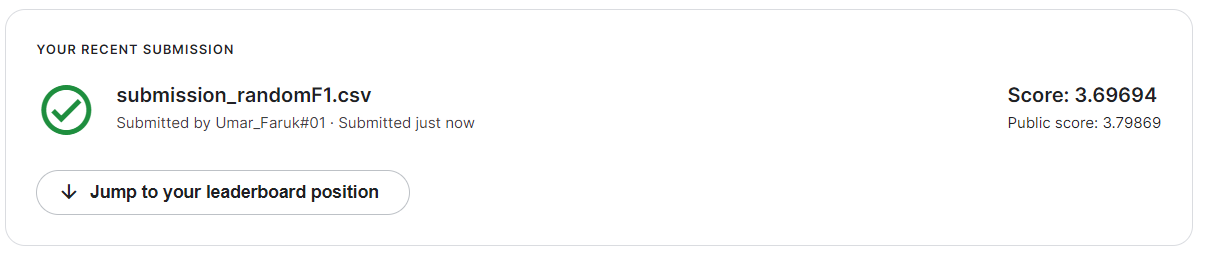

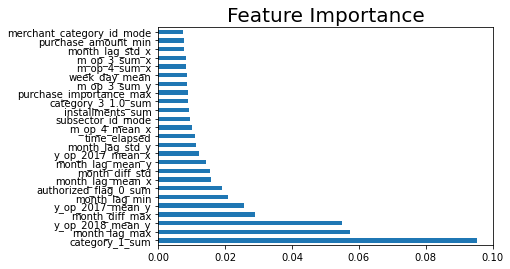

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index= X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.title('Feature Importance', fontsize = 20)
plt.show()

### LGBM 

In [ ]:
model = lgb.LGBMRegressor( n_jobs=-1, 
                      num_leaves = 145,
                      n_estimators = 450,
                      max_depth = 7,
                      learning_rate = 0.009,
                      colsample_bytree = 0.6)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Test RMSE: {:2.5f}".format(test_rmse))


Train RMSE: 3.50047
Test RMSE: 3.72519


In [ ]:
test = test_final.drop(['card_id','first_active_month'], axis =1)

In [ ]:
predictions = model.predict(test)

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_lgbm1.csv", index=False)

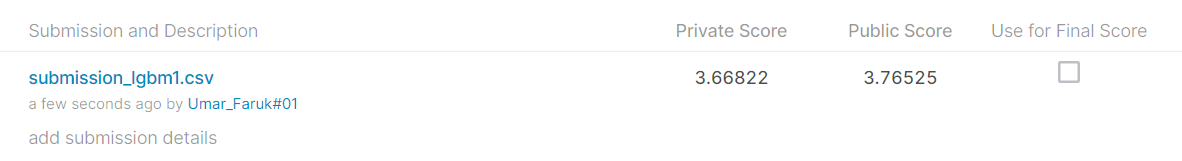

In [ ]:
y_train = train_final.target
train_card_ids = train_final['card_id']
outliers = train_final.rare_value
X_train = train_final.drop(columns=['card_id', 'target','rare_value'])

### SGD

In [ ]:
model = SGDRegressor()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Test RMSE: {:2.5f}".format(test_rmse))

Train RMSE: 52662950274490236928.00000
Test RMSE: 46919890837247172608.00000


###lgbm_folds

In [ ]:
train = train_final

In [ ]:
test = test_final

In [ ]:
features = [c for c in train.columns if c not in ['card_id','rare_value','target']]
#features = [f for f in features if f not in unimportant_features]
#categorical_feats = ['feature_2', 'feature_3']
param = {'num_leaves': 180,
         'n_estimators' : 450,
         'max_depth' : 7,
         'learning_rate' : .009,
         'colsample_bytree' : 0.6,
         'n_jobs' : -1,
         "metric": 'rmse'}


In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof1 = np.zeros(len(train))
predictions_kf = np.zeros(len(test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train.target.values )):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label= train.target.iloc[trn_idx]
                           #categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label= train.target.iloc[val_idx]
                           #categorical_feature=categorical_feats
                          )
    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof1[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_kf += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof1, train.target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68316	valid_1's rmse: 3.77807
[200]	training's rmse: 3.59458	valid_1's rmse: 3.74652
[300]	training's rmse: 3.54696	valid_1's rmse: 3.73581
[400]	training's rmse: 3.51313	valid_1's rmse: 3.7307
[500]	training's rmse: 3.48451	valid_1's rmse: 3.72827
[600]	training's rmse: 3.46049	valid_1's rmse: 3.72716
[700]	training's rmse: 3.43692	valid_1's rmse: 3.72635
[800]	training's rmse: 3.41562	valid_1's rmse: 3.72609
[900]	training's rmse: 3.39562	valid_1's rmse: 3.72493
[1000]	training's rmse: 3.37793	valid_1's rmse: 3.72467
[1100]	training's rmse: 3.35998	valid_1's rmse: 3.72441
[1200]	training's rmse: 3.34323	valid_1's rmse: 3.72468
[1300]	training's rmse: 3.32592	valid_1's rmse: 3.72529
Early stopping, best iteration is:
[1150]	training's rmse: 3.35091	valid_1's rmse: 3.72427
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.70242	valid_1's rmse: 

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions_sk
sub_df.to_csv("submission_kfold1.csv", index=False)

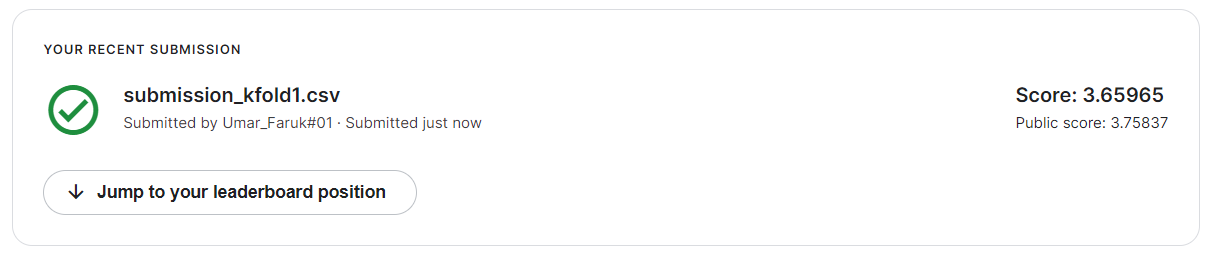

In [ ]:
pickle.dump((oof1,predictions_kf), open('kf_data','wb'))
pickle.dump(clf, open('kf_fold', 'wb'))

### Stratified folds

In [ ]:
target = train_final.target

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof2 = np.zeros(len(train))
predictions_skf = np.zeros(len(test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['rare_value'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 300)
    oof2[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    
    predictions_skf += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof2, target))

fold 0
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 3.68722	valid_1's rmse: 3.75588
[200]	training's rmse: 3.59819	valid_1's rmse: 3.72788
[300]	training's rmse: 3.54753	valid_1's rmse: 3.71754
[400]	training's rmse: 3.5136	valid_1's rmse: 3.71371
[500]	training's rmse: 3.48461	valid_1's rmse: 3.71174
[600]	training's rmse: 3.45999	valid_1's rmse: 3.71023
[700]	training's rmse: 3.43647	valid_1's rmse: 3.70927
[800]	training's rmse: 3.41468	valid_1's rmse: 3.70873
[900]	training's rmse: 3.39271	valid_1's rmse: 3.70861
[1000]	training's rmse: 3.37493	valid_1's rmse: 3.70813
[1100]	training's rmse: 3.357	valid_1's rmse: 3.70744
[1200]	training's rmse: 3.33947	valid_1's rmse: 3.70752
[1300]	training's rmse: 3.32309	valid_1's rmse: 3.70741
[1400]	training's rmse: 3.30741	valid_1's rmse: 3.70784
[1500]	training's rmse: 3.29004	valid_1's rmse: 3.70805
[1600]	training's rmse: 3.27345	valid_1's rmse: 3.70837
Early stopping, best iteration is:
[1301]	trai

3.702129777316479

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions_skf
sub_df.to_csv("submission_str_kfold1.csv", index=False)

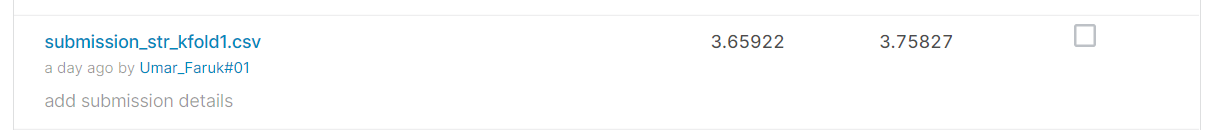

In [ ]:
pickle.dump((oof2,predictions_skf), open('skf_data','wb'))
pickle.dump(clf, open('skf_fold', 'wb'))

### Stacking with stratifed kfold with oof1 & oof2

In [ ]:
from sklearn.linear_model import Ridge

train_stack = np.vstack([oof1, oof2]).transpose()
test_stack = np.vstack([predictions_kf, predictions_skf]).transpose()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train['rare_value'].values)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / folds.n_splits

np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
fold n°1
fold n°2
fold n°3
fold n°4


3.700448110974923

In [ ]:
sub_df = pd.DataFrame({"card_id":test_final["card_id"].values})
sub_df["target"] = predictions_stack
sub_df.to_csv("submission_str_stack1.csv", index=False)

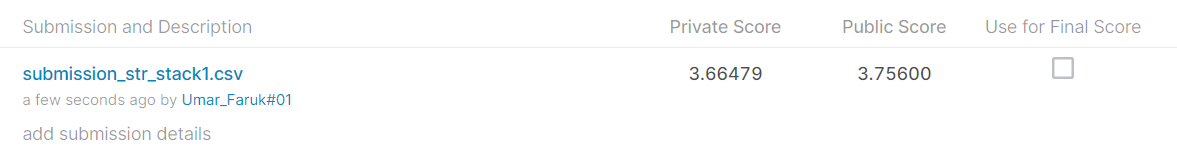

In [ ]:
pickle.dump((oof_stack,predictions_stack), open('stack_data','wb'))
pickle.dump(clf, open('model_stack', 'wb'))

In [ ]:
#exporting target and rare values
pickle.dump((train['rare_value'],target), open('rare&target_values','wb'))

In [ ]:
len(oof1)

201917

In [ ]:
len(train_stack)

201917

In [ ]:
train_stack.shape

(201917, 2)

In [ ]:
oof1.shape

(201917,)

In [ ]:
test_stack.shape

(123623, 2)

In [ ]:
oof_stack.shape

(201917,)